In [1]:
%matplotlib inline

In [2]:
import os
import sys

In [3]:
print sys.version

2.7.14 (default, Jan 17 2018, 15:13:18) 
[GCC 4.2.1 Compatible Apple LLVM 9.0.0 (clang-900.0.39.2)]


In [70]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import networkx as nx
from tqdm import tqdm_notebook

In [5]:
from utils import get_xyz_data, get_size
from utils import get_factor, get_crytal_graph, convert_to_red, get_shortest_distances

/usr/local/lib/python2.7/site-packages/pymatgen/__init__.py:87: UserWarning: 
Pymatgen will drop Py2k support from v2019.1.1. Pls consult the documentation
at https://www.pymatgen.org for more details.
  at https://www.pymatgen.org for more details.""")


In [6]:
from properties import get_element_properties
from properties import ElementExtended

In [7]:
DATA_DIR = './data'

#### Get base train and test data

In [8]:
train = pd.read_csv(os.path.join(DATA_DIR, 'train.csv'),
                    names=['id', 'spacegroup', 'natoms', 'al',
                           'ga', 'in', 'a', 'b', 'c',
                           'alpha', 'beta',
                           'gamma', 'E0',
                           'bandgap'],
                    header=0,
                    sep=',')
test = pd.read_csv(os.path.join(DATA_DIR, 'test.csv'),
                    names=['id', 'spacegroup', 'natoms', 'al',
                           'ga', 'in', 'a', 'b', 'c',
                           'alpha', 'beta',
                           'gamma'],
                    header=0,
                    sep=',')

In [43]:
train.head()

,id,spacegroup,natoms,al,ga,in,a,b,c,alpha,beta,gamma,E0,bandgap
0,1,33,80.0,0.6250,0.3750,0.000,9.9523,8.5513,9.1775,90.0026,90.0023,90.0017,0.0680,3.4387
1,2,194,80.0,0.6250,0.3750,0.000,6.1840,6.1838,23.6287,90.0186,89.9980,120.0025,0.2490,2.9210
2,3,227,40.0,0.8125,0.1875,0.000,9.7510,5.6595,13.9630,90.9688,91.1228,30.5185,0.1821,2.7438
3,4,167,30.0,0.7500,0.0000,0.250,5.0036,5.0034,13.5318,89.9888,90.0119,120.0017,0.2172,3.3492
4,5,194,80.0,0.0000,0.6250,0.375,6.6614,6.6612,24.5813,89.9960,90.0006,119.9893,0.0505,1.3793


In [51]:
test.head()

,id,spacegroup,natoms,al,ga,in,a,b,c,alpha,beta,gamma
0,1,33,80.0,0.1875,0.4688,0.3438,10.5381,9.0141,9.6361,89.9997,90.0003,90.0006
1,2,33,80.0,0.7500,0.2500,0.0000,9.8938,8.5014,9.1298,90.0038,90.0023,90.0015
2,3,167,30.0,0.6667,0.1667,0.1667,4.9811,4.9808,13.4799,89.9900,90.0109,120.0014
3,4,12,80.0,0.5625,0.4375,0.0000,24.3370,6.0091,5.7620,89.9995,103.8581,90.0002
4,5,12,80.0,0.1875,0.5000,0.3125,24.6443,6.2906,6.1589,90.0000,104.5929,90.0001


#### Get element properties from files (as check)

In [9]:
elem_properties = get_element_properties(DATA_DIR)

In [10]:
elem_properties

,element,ea,ip,rs_max,rp_max,rd_max
0,In,-0.312500,-5.537400,1.09,1.390000,1.940000
1,Ga,-0.108100,-5.818200,0.99,1.330000,2.160000
2,Al,-0.256300,-5.780000,1.13,1.500000,3.110000
3,O,-0.225633,-5.711867,1.07,1.406667,2.403333


#### Process an example file

In [11]:
idx = 1
fname = os.path.join(DATA_DIR, '{}', '{}', 'geometry.xyz').format('train', idx)

In [12]:
pos, lat, natoms = get_xyz_data(fname)

In [13]:
pos.head()

,x,y,z,element,electroneg,atomic_mass,r_ionic,ea,ip,rs_max,rp_max,rd_max
0,1.608888,7.276416,6.383155,Ga,1.81,69.723000,0.760,-0.1081,-5.8182,0.99,1.33,2.16
1,6.584932,7.252792,6.365826,Al,1.61,26.981539,0.675,-0.2563,-5.7800,1.13,1.50,3.11
2,3.435758,1.259776,1.794613,Al,1.61,26.981539,0.675,-0.2563,-5.7800,1.13,1.50,3.11
3,8.411802,1.236152,1.777284,Ga,1.81,69.723000,0.760,-0.1081,-5.8182,0.99,1.33,2.16
4,0.955880,2.998925,1.801351,Ga,1.81,69.723000,0.760,-0.1081,-5.8182,0.99,1.33,2.16


In [14]:
lat

array([[ 9.95208772e+00, -4.72482400e-02, -3.46579300e-02],
       [ 4.03159900e-02,  8.55117485e+00, -9.53377000e-03],
       [ 3.16403800e-02,  9.66592000e-03,  9.17743912e+00]])

In [15]:
natoms

element
Al    20
Ga    12
O     48
dtype: int64

In [16]:
pos_R = pos[['x', 'y', 'z']].as_matrix()

In [17]:
pos_red = convert_to_red(pos_R, lat)

In [18]:
pos_all = pos.join(pd.DataFrame(pos_red, columns=['x_red', 'y_red', 'z_red']))
pos_all.head()

,x,y,z,element,electroneg,atomic_mass,r_ionic,ea,ip,rs_max,rp_max,rd_max,x_red,y_red,z_red
0,1.608888,7.276416,6.383155,Ga,1.81,69.723000,0.760,-0.1081,-5.8182,0.99,1.33,2.16,0.156,0.851,0.697
1,6.584932,7.252792,6.365826,Al,1.61,26.981539,0.675,-0.2563,-5.7800,1.13,1.50,3.11,0.656,0.851,0.697
2,3.435758,1.259776,1.794613,Al,1.61,26.981539,0.675,-0.2563,-5.7800,1.13,1.50,3.11,0.344,0.149,0.197
3,8.411802,1.236152,1.777284,Ga,1.81,69.723000,0.760,-0.1081,-5.8182,0.99,1.33,2.16,0.844,0.149,0.197
4,0.955880,2.998925,1.801351,Ga,1.81,69.723000,0.760,-0.1081,-5.8182,0.99,1.33,2.16,0.094,0.351,0.197


In [19]:
dists, Rij_min = get_shortest_distances(pos_red, lat)

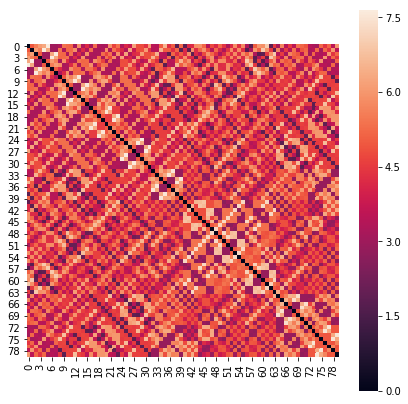

In [20]:
plt.subplots(figsize=(7, 7))
sns.heatmap(dists, square=True);

#### Make crystal graph

In [44]:
cg_factor = get_factor(train.iloc[idx - 1].spacegroup, train.iloc[idx - 1].gamma)

G = get_crytal_graph(pos_red, pos.element, dists, factor=cg_factor)

print "Spacegroup:", train.iloc[idx - 1].spacegroup
print "Gamma:", train.iloc[idx - 1].gamma
print "CG Factor:", cg_factor
print "Node count:", G.number_of_nodes()
print "Edge count:", G.number_of_edges()

for i in range(len(pos.element)):
    sym_i = pos.element[i]
    node_i = '{}_{}'.format(sym_i, i)
    crdn_i = list(G.neighbors(node_i))
    print "{:8s}{:d}   {}".format(node_i, len(crdn_i), crdn_i)

Spacegroup: 33.0
Gamma: 90.0017
CG Factor: 1.4
Node count: 80
Edge count: 176
Ga_0    4   ['O_40', 'O_38', 'O_57', 'O_62']
Al_1    4   ['O_39', 'O_41', 'O_56', 'O_63']
Al_2    4   ['O_42', 'O_60', 'O_59', 'O_36']
Ga_3    4   ['O_43', 'O_37', 'O_58', 'O_61']
Ga_4    4   ['O_45', 'O_60', 'O_58', 'O_34']
Al_5    4   ['O_59', 'O_44', 'O_35', 'O_61']
Al_6    4   ['O_32', 'O_56', 'O_47', 'O_62']
Al_7    4   ['O_33', 'O_57', 'O_46', 'O_63']
Al_8    6   ['O_38', 'O_45', 'O_33', 'O_54', 'O_48', 'O_78']
Ga_9    6   ['O_39', 'O_44', 'O_55', 'O_32', 'O_49', 'O_79']
Ga_10   6   ['O_36', 'O_76', 'O_47', 'O_50', 'O_35', 'O_52']
Al_11   6   ['O_37', 'O_77', 'O_46', 'O_51', 'O_53', 'O_34']
Al_12   6   ['O_40', 'O_74', 'O_34', 'O_51', 'O_36', 'O_52']
Ga_13   6   ['O_75', 'O_41', 'O_53', 'O_37', 'O_50', 'O_35']
Al_14   6   ['O_42', 'O_38', 'O_72', 'O_54', 'O_32', 'O_49']
Ga_15   6   ['O_55', 'O_43', 'O_39', 'O_73', 'O_33', 'O_48']
Ga_16   6   ['O_64', 'O_42', 'O_38', 'O_73', 'O_58', 'O_48']
Al_17   6   [

In [45]:
G.node['Ga_0']

{'atomic_mass': 69.723, 'cn': 4, 'electroneg': 1.81, 'symbol': 'Ga'}

In [46]:
G.edges[('Ga_0', 'O_38', 0)]

{'bond_length': 1.808885609695628, 'symbol': 'Ga-O'}

In [47]:
G['Ga_0']

AdjacencyView({'O_40': {0: {'bond_length': 1.8271305422232218, 'symbol': 'Ga-O'}}, 'O_38': {0: {'bond_length': 1.808885609695628, 'symbol': 'Ga-O'}}, 'O_57': {0: {'bond_length': 1.781654092682299, 'symbol': 'Ga-O'}}, 'O_62': {0: {'bond_length': 1.859283310839619, 'symbol': 'Ga-O'}}})

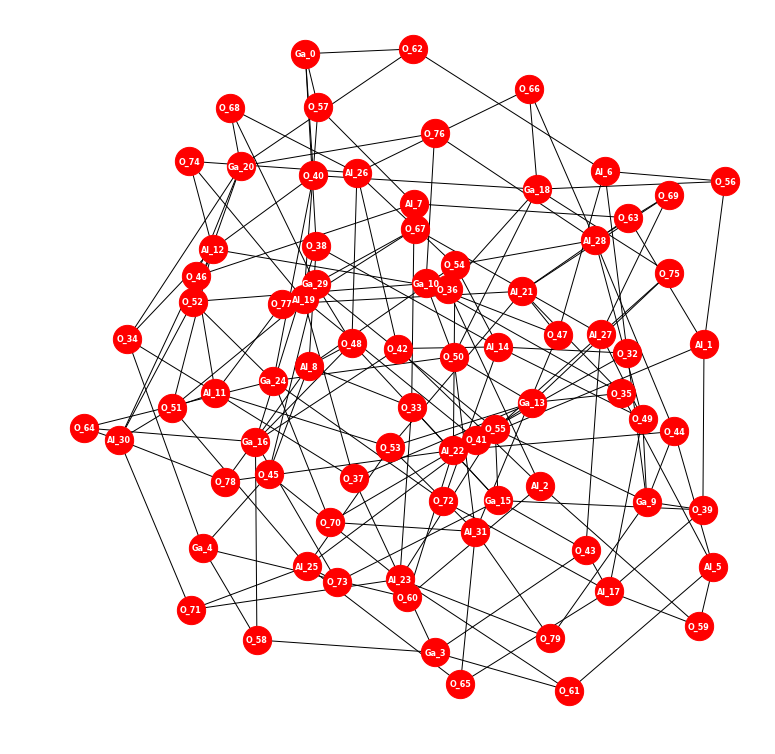

In [48]:
plt.figure(figsize=(10, 10))
nx.draw_spring(G, with_labels=True, node_size=800, font_size=8, font_color='w', font_weight='bold');

In [49]:
for e in G.edges(data=True):
    print e

('Ga_24', 'O_64', {'bond_length': 1.7713028803556745, 'symbol': 'Ga-O'})
('Ga_24', 'O_40', {'bond_length': 2.082770136365895, 'symbol': 'Ga-O'})
('Ga_24', 'O_72', {'bond_length': 1.84925884609136, 'symbol': 'Ga-O'})
('Ga_24', 'O_70', {'bond_length': 1.8657425753395287, 'symbol': 'Ga-O'})
('Ga_24', 'O_50', {'bond_length': 2.13738661214414, 'symbol': 'Ga-O'})
('Ga_24', 'O_52', {'bond_length': 2.329136453583531, 'symbol': 'Ga-O'})
('O_75', 'Ga_18', {'bond_length': 1.9017018944213258, 'symbol': 'Ga-O'})
('O_75', 'Ga_13', {'bond_length': 1.8168774463107993, 'symbol': 'Ga-O'})
('O_75', 'Al_27', {'bond_length': 1.8492244642819242, 'symbol': 'Al-O'})
('O_60', 'Al_2', {'bond_length': 1.8593069133982711, 'symbol': 'Al-O'})
('O_60', 'Ga_4', {'bond_length': 1.781702613951043, 'symbol': 'Ga-O'})
('O_60', 'Al_22', {'bond_length': 1.8562114690805633, 'symbol': 'Al-O'})
('Ga_20', 'O_76', {'bond_length': 1.9017036317436342, 'symbol': 'Ga-O'})
('Ga_20', 'O_46', {'bond_length': 1.9668713895132355, 'symbo

In [50]:
for n in G.nodes(data=True):
    print n

('Ga_24', {'symbol': 'Ga', 'electroneg': 1.81, 'atomic_mass': 69.723, 'cn': 6})
('O_75', {'symbol': 'O', 'electroneg': 3.44, 'atomic_mass': 15.9994, 'cn': 3})
('O_60', {'symbol': 'O', 'electroneg': 3.44, 'atomic_mass': 15.9994, 'cn': 3})
('Ga_20', {'symbol': 'Ga', 'electroneg': 1.81, 'atomic_mass': 69.723, 'cn': 6})
('O_62', {'symbol': 'O', 'electroneg': 3.44, 'atomic_mass': 15.9994, 'cn': 3})
('O_63', {'symbol': 'O', 'electroneg': 3.44, 'atomic_mass': 15.9994, 'cn': 3})
('O_73', {'symbol': 'O', 'electroneg': 3.44, 'atomic_mass': 15.9994, 'cn': 3})
('Ga_29', {'symbol': 'Ga', 'electroneg': 1.81, 'atomic_mass': 69.723, 'cn': 6})
('O_42', {'symbol': 'O', 'electroneg': 3.44, 'atomic_mass': 15.9994, 'cn': 4})
('O_33', {'symbol': 'O', 'electroneg': 3.44, 'atomic_mass': 15.9994, 'cn': 4})
('O_40', {'symbol': 'O', 'electroneg': 3.44, 'atomic_mass': 15.9994, 'cn': 4})
('O_41', {'symbol': 'O', 'electroneg': 3.44, 'atomic_mass': 15.9994, 'cn': 4})
('O_46', {'symbol': 'O', 'electroneg': 3.44, 'ato

#### Process all files (test and train)

In [71]:
def process_graph(batch='train'):
    """
    Function to process each .xyz file and return the crystal graph
    """
    summary_result = []
    
    pbar = tqdm_notebook(os.listdir(os.path.join(DATA_DIR, batch)))
    
    for i in pbar:
        # Load .xyz data
        fname = os.path.join(DATA_DIR, batch, i, 'geometry.xyz')
        pos, latvec, natoms = get_xyz_data(fname)
        
        # Calculate reduced coordinates
        pos_R = pos[['x', 'y', 'z']].as_matrix()
        pos_red = convert_to_red(pos_R, lat)
        
        # Get distances between pairs
        dists, Rij_min = get_shortest_distances(pos_red, lat)
        
        # Make CG
        if batch == 'train':
            d = train.iloc[int(i) - 1]
        elif batch == 'test':
            d = test.iloc[int(i) - 1]
        cg_factor = get_factor(d.spacegroup, d.gamma)
        G = get_crytal_graph(pos_red, pos.element, dists, factor=cg_factor)
        
        summary_result.append(G)
    
    return summary_result

In [ ]:
Glist_check = process_graph(batch='train')

HBox(children=(IntProgress(value=0, max=2400), HTML(value=u'')))